<a href="https://colab.research.google.com/github/Julia891021/Artificial_Introduction_Team31/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch
!pip install torchvision
!pip install ipywidgets

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=f44cdf670b39525849d8ea9c579ff4f056849c59ae52d833876c2b47a1283a04
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/stats500_final_colab /content/project_1204

import os
os.chdir('/content/project_1204')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Library

In [ ]:
# Check data directory
os.listdir("FaceShape Dataset")

['testing_set', 'desktop.ini', 'training_set']

### Split train, val

In [ ]:
def split_train_val(data_dir, val_size=0.1, random_state=42):
    train, test = [], []
    for dset in os.listdir(data_dir):
        # check is directory
        subdir = os.path.join(data_dir, dset)
        if os.path.isdir(subdir):
            for label in os.listdir(subdir):
                imgdir = os.path.join(subdir, label)
                if os.path.isdir(imgdir):
                    for image_path in os.listdir(imgdir):
                        if image_path.endswith(".jpg"):
                            sample = {
                                "path": os.path.join(subdir, label, image_path),
                                "label": label
                            }
                            if dset == "training_set":
                                train.append(sample)
                            elif dset == "testing_set":
                                test.append(sample)

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train, val = train_test_split(train, test_size=val_size, random_state=random_state)
    # save to csv
#     train_path, val_path, test_path = os.path.join(data_dir, "train.csv"), os.path.join(data_dir, "val.csv"), os.path.join(data_dir, "test.csv")
#     train.to_csv(train_path, index=False)
#     val.to_csv(val_path, index=False)
#     test.to_csv(test_path, index=False)

    return train, val, test

train_df, val_df, test_df = split_train_val("FaceShape Dataset")
test_df

path   label
0     FaceShape Dataset/testing_set/Oblong/oblong (9...  Oblong
1     FaceShape Dataset/testing_set/Oblong/oblong (7...  Oblong
2     FaceShape Dataset/testing_set/Oblong/oblong (5...  Oblong
3     FaceShape Dataset/testing_set/Oblong/oblong (8...  Oblong
4     FaceShape Dataset/testing_set/Oblong/oblong (8...  Oblong
...                                                 ...     ...
1009  FaceShape Dataset/testing_set/Heart/heart (769...   Heart
1010  FaceShape Dataset/testing_set/Heart/heart (102...   Heart
1011  FaceShape Dataset/testing_set/Heart/heart (912...   Heart
1012  FaceShape Dataset/testing_set/Heart/heart (757...   Heart
1013  FaceShape Dataset/testing_set/Heart/heart (851...   Heart

[1014 rows x 2 columns]

### Visualize some images and labels

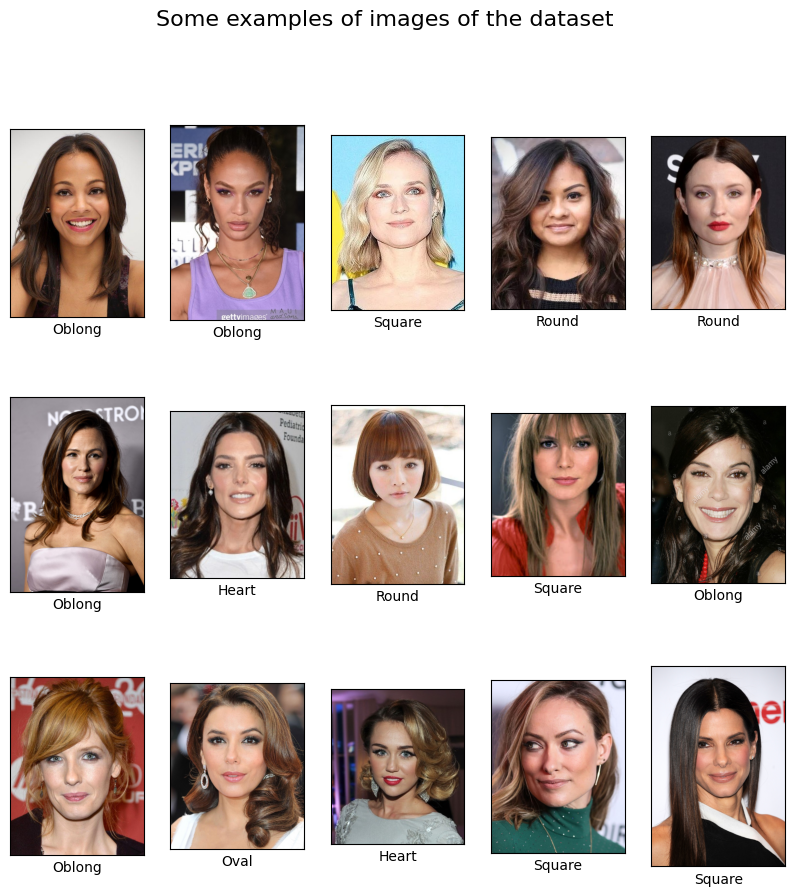

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_examples():

    """
        Display 15 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = train_df.iloc[i]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(train_df.iloc[i]["label"])
    plt.show()

display_examples()


### Dataset

In [ ]:
# Dataset
class FaceShapeDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, split="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.split = split
        class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
        self.label2idx = {class_name:i for i, class_name in enumerate(class_names)}
        self.idx2label = {v:k for k,v in self.label2idx.items()}

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)

            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)
        except:
            print(f"Error load image {img_path}")
            idx = 0
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)

            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)

### EfficientNet

In [ ]:
# Models
class EffNet(nn.Module):
    def __init__(self, num_classes=5):
        super(EffNet, self).__init__()
        self.eff = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes, in_channels=1)
    def forward(self, x):
        x = self.eff(x)
        return x

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Epoch {}".format(epoch+1))
        for batch_idx, (data, target) in bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())


        model.eval()
        val_loss = 0
        correct = 0

        with torch.no_grad():
            bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Epoch {}".format(epoch+1))
            for batch_idx, (data, target) in bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            val_accuracy))

        # save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "./best_model1.pth")
            print("Saved best model")
        print("Best accuracy: {}".format(best_accuracy))

    return model

In [ ]:
# Configs
class args:
    data_dir="FaceShape Dataset"
    batch_size=10
    n_epochs=20
    learning_rate=0.001
    debug=False

In [ ]:
train_df, val_df, test_df = split_train_val(args.data_dir)
if args.debug:
    train_df, val_df = train_df.sample(n=10).reset_index(drop=True), val_df.sample(n=10).reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(train_df, transform=transform, split="train"),
    batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(val_df, transform=transform, split="val"),
    batch_size=args.batch_size, shuffle=False
)

### Start Training



In [ ]:
# import time
# from datetime import timedelta
# st = time.time()
# print("-------- Start training --------")
# model = EffNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
# model = train(model, train_loader, val_loader, criterion, optimizer, epochs=args.n_epochs, device=device)
# print("-------- End training, time taken:", timedelta(seconds=int(time.time()-st)))

### Load Pretrined model

In [ ]:
path = '/content/project_1204/best_model.pth'
model = EffNet().to(device)
model.load_state_dict(torch.load(path))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


100%|██████████| 117M/117M [00:04<00:00, 26.7MB/s]


Loaded pretrained weights for efficientnet-b5


<All keys matched successfully>

### Predict on test set

In [ ]:
test_ds = FaceShapeDataset(test_df, transform=transform, split="test")
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=args.batch_size, shuffle=False
)
model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
prob_list = []
with torch.no_grad():
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      y_true += target.view(-1).tolist()
      y_pred += pred.view(-1).tolist()

test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

y_true = [test_ds.idx2label[i] for i in y_true]
y_pred = [test_ds.idx2label[i] for i in y_pred]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test set: Average loss: 1.0168, Accuracy: 768/1014 (76%)

              precision    recall  f1-score   support

       Heart       0.76      0.69      0.72       201
      Oblong       0.81      0.80      0.81       203
        Oval       0.62      0.68      0.65       208
       Round       0.72      0.82      0.77       202
      Square       0.90      0.80      0.85       200

    accuracy                           0.76      1014
   macro avg       0.77      0.76      0.76      1014
weighted avg       0.76      0.76      0.76      1014



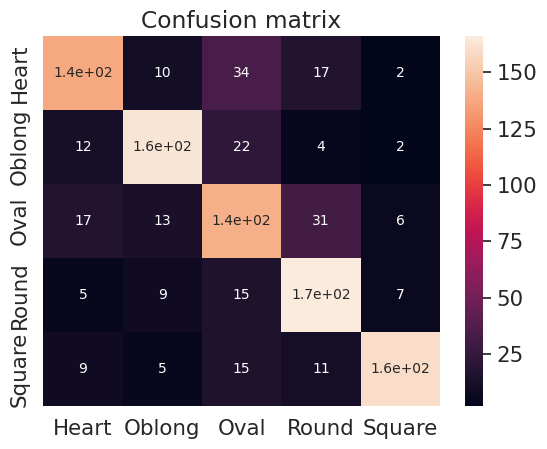

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.label2idx.keys())
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

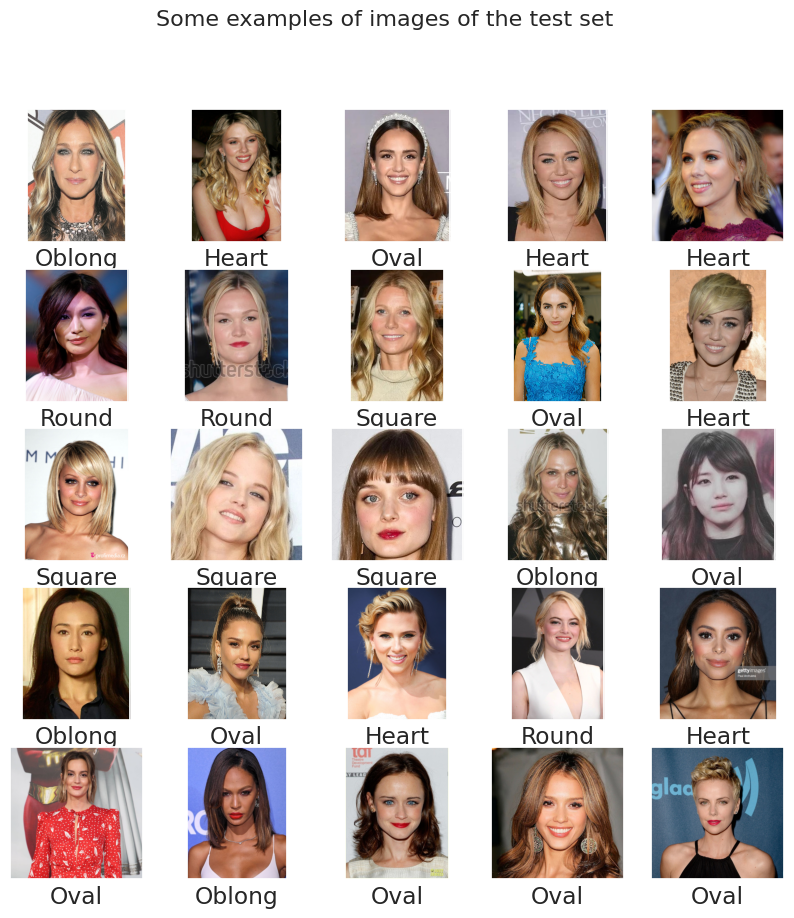

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(25)]

def display_examples():

    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_true[idx])
    plt.show()

display_examples()


### Face-Shape Prediction and Top-3 Similarity-Based Hairstyle Recommendation




In [ ]:
!pip install mediapipe>=0.10.14
import os
import cv2
import numpy as np
import mediapipe as mp
from PIL import Image, ImageDraw
import torchvision.transforms as T

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
mp_face = mp.solutions.face_detection

def crop_face_with_mediapipe(img_bgr):
    h, w, _ = img_bgr.shape
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    with mp_face.FaceDetection(model_selection=1,
                               min_detection_confidence=0.5) as detector:
        results = detector.process(img_rgb)

    if not results.detections:
        print("⚠️ no face detected")
        return None

    det = results.detections[0]
    box = det.location_data.relative_bounding_box

    x1 = int(box.xmin * w)
    y1 = int(box.ymin * h)
    x2 = int((box.xmin + box.width) * w)
    y2 = int((box.ymin + box.height) * h)

    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    face = img_bgr[y1:y2, x1:x2]
    return face

def image_feature_vector(img_bgr):
    img = cv2.resize(img_bgr, (224, 224))
    hist = cv2.calcHist([img], [0, 1, 2], None,
                        [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()


In [ ]:
def get_Remove_BG(img_path, y_pred):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise ValueError(f"Cannot load image: {img_path}")

    # Detect and crop the face using Mediapipe
    face_bgr = crop_face_with_mediapipe(img_bgr)
    if face_bgr is None:
        print("No face detected. Using the full image.")
        face_bgr = img_bgr.copy()

    # Extract feature vector of the input image
    known_feat = image_feature_vector(face_bgr)

    # Load hairstyle sample images
    dataPath = os.path.join(os.getcwd(), "Hair_Sample", y_pred)
    foldername = os.listdir(dataPath)

    new_image_path_list = [
        os.path.join(dataPath, fname)
        for fname in foldername
        if fname.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    # Compute distances between the input image and sample images
    distances = []
    for p in new_image_path_list:
        sample_bgr = cv2.imread(p)
        if sample_bgr is None:
            continue
        sample_feat = image_feature_vector(sample_bgr)
        dist = np.linalg.norm(known_feat - sample_feat)
        distances.append((dist, p))

    if not distances:
        print("No hairstyle samples found.")
        return img_bgr, []

    print([d for d, _ in distances])

    # Select the three closest hairstyle images
    distances.sort(key=lambda x: x[0])
    top3 = distances[:3]

    result = []
    for _, p in top3:
        sample = cv2.imread(p)
        result.append(sample)

    return img_bgr, result


index:  742
Round
[np.float32(1.3242327), np.float32(1.1643829), np.float32(1.040193), np.float32(1.2769369), np.float32(1.206941), np.float32(1.263635), np.float32(1.1856762), np.float32(1.1604906), np.float32(1.152178), np.float32(1.3221383), np.float32(1.2247862), np.float32(1.2180283), np.float32(1.254798), np.float32(1.2046977), np.float32(1.3516461), np.float32(1.2617623), np.float32(1.239309), np.float32(1.3380296), np.float32(1.2458436), np.float32(1.3143094), np.float32(1.1979448)]


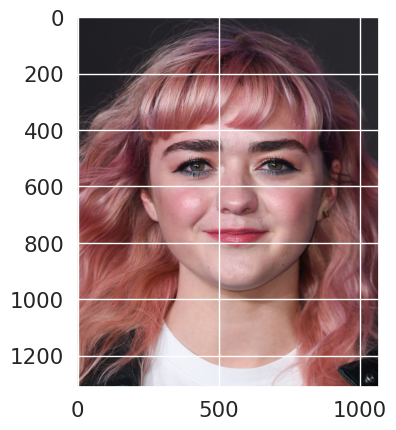

In [ ]:
for i in range(test_df.shape[0]):
  if test_df['path'][i] == 'FaceShape Dataset/testing_set/Round/round (15).jpg':
    index=i
    print('index: ',i)
print(y_pred[index])
os.chdir(os.getcwd())
pic,hair=get_Remove_BG(test_df['path'][index], y_pred[index])
plt.imshow(pic[:, :, [2, 1, 0]] )
# pic.shape
# plt.imshow(hair[1])

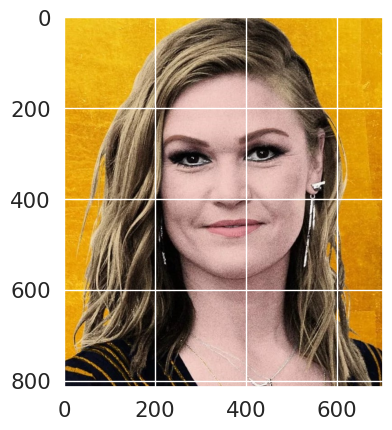

In [ ]:
plt.imshow(hair[0][:, :, [2, 1, 0]])

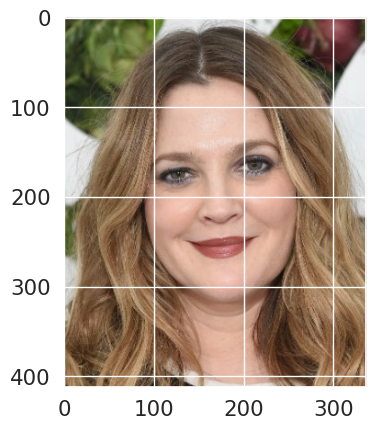

In [ ]:
plt.imshow(hair[1][:, :, [2, 1, 0]])

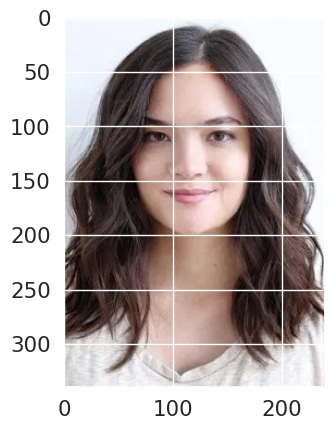

In [ ]:
plt.imshow(hair[2][:, :, [2, 1, 0]])

In [ ]:
os.chdir('/content/project_1204/Barbershop-main/unprocessed')
cv2.imwrite('original_pic_'+str(index)+'.jpeg', pic)
for i in range(len(hair)):
  cv2.imwrite('hair'+str(i)+'_'+str(index)+'.jpeg', hair[i])

In [ ]:
import os
os.chdir('/content/project_1204/Barbershop-main')

In [ ]:
!pip install Ninja
!python align_face.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.7 MB/s eta 0:00:00
2025-12-07 22:46:32.166970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765147592.186362   14716 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765147592.192259   14716 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765147592.207117   14716 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765147592.207143   14716 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

In [ ]:
!python main.py --im_path1 original_pic_742.png --im_path2 hair0_742.png --im_path3 hair0_742.png --sign realistic --smooth 5  --device cuda

Downloading...
From (original): https://drive.google.com/uc?id=1AT6bNR2ppK8f2ETL_evT27f3R_oyWNHS
From (redirected): https://drive.google.com/uc?id=1AT6bNR2ppK8f2ETL_evT27f3R_oyWNHS&confirm=t&uuid=35c12e38-b131-4eed-8789-0a371fd327df
To: /content/project_1204/Barbershop-main/pretrained_models/ffhq.pt
100% 133M/133M [00:02<00:00, 58.9MB/s]
Loading StyleGAN2 from checkpoint: pretrained_models/ffhq.pt
Setting up Perceptual loss...
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get th

In [ ]:
!python main.py --im_path1 original_pic_742.png --im_path2 hair1_742.png --im_path3 hair1_742.png --sign realistic --smooth 5

Loading StyleGAN2 from checkpoint: pretrained_models/ffhq.pt
Setting up Perceptual loss...
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading model from: /content/project_1204/Barbershop-main/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Number of images: 2
Images:   0% 0/2 [00:00<?, ?it/s]
Embedding:   0% 0/1100 [00:00<?, ?it/s]
Embedding:   0% 1/1100 [00:00<12:28,  1.47it/s]
Embedding:   0% 3/1

In [ ]:
!python main.py --im_path1 original_pic_742.png --im_path2 hair2_742.png --im_path3 hair2_742.png --sign realistic --smooth 5

Loading StyleGAN2 from checkpoint: pretrained_models/ffhq.pt
Setting up Perceptual loss...
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loading model from: /content/project_1204/Barbershop-main/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Number of images: 2
Images:   0% 0/2 [00:00<?, ?it/s]
Embedding:   0% 0/1100 [00:00<?, ?it/s]
Embedding:   0% 1/1100 [00:00<12:36,  1.45it/s]
Embedding:   0% 3/1

In [ ]:
os.chdir('/content/project_1204/Barbershop-main/output')
image1 = '/content/project_1204/Barbershop-main/output/original_pic_742_hair0_742_hair0_742_realistic.png'
image2 = '/content/project_1204/Barbershop-main/output/original_pic_742_hair1_742_hair1_742_realistic.png'
image3 = '/content/project_1204/Barbershop-main/output/original_pic_742_hair2_742_hair2_742_realistic.png'

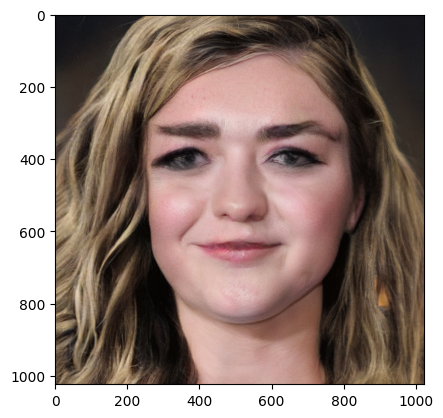

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(image1)
plt.imshow(image[:, :, [2, 1, 0]])

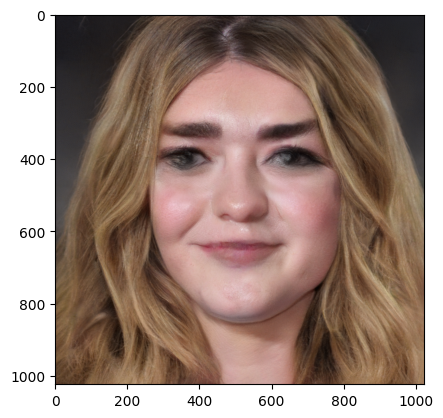

In [ ]:
image = cv2.imread(image2)
plt.imshow(image[:, :, [2, 1, 0]])

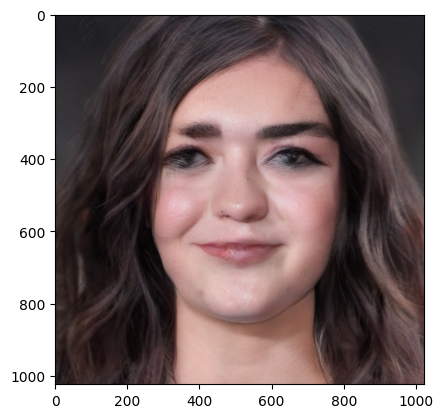

In [ ]:
image = cv2.imread(image3)
plt.imshow(image[:, :, [2, 1, 0]])

In [ ]:
os.chdir('/content/project_1204')
!pip install pipreqs

In [ ]:
!pipreqs ./

INFO: Not scanning for jupyter notebooks.


In [ ]:
%cd /content
!zip -r project_1204.zip project_1204


Streaming output truncated to the last 5000 lines.
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (893).jpg (deflated 10%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (964).jpg (deflated 1%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (885).jpg (deflated 0%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (8).jpg (deflated 45%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (81).jpg (deflated 0%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (158).jpg (deflated 16%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (22).jpg (deflated 45%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (683).jpg (deflated 0%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (34).jpg (deflated 1%)
  adding: project_1204/FaceShape Dataset/testing_set/Oblong/oblong (327).jpg (deflated 40%)
  adding: project_1204/FaceShape Datase

In [ ]:
!cp -r project_1204 /content/drive/MyDrive/